# Chroma from Luma (CfL)

Outline
* Intro
  * ~~Overall description~~
  * ~~Other CfL Implementation~~
  * ~~How this is different~~
* Fundamentals
  * ~~Model fitting~~
  * ~~Simplifications~~
* Quantization
* Signaling
* Integration with AV1
* Results

## Introduction

Chroma from Luma (CfL) is a coding tool that predicts information in the chromatic planes based on previously encoded information in the Luma plane. The underlining assumption is that a correlation exists between the Luma plane and its chromatic counterparts. This correlation can be seen in the following image, notice the ressemblance between the chromatic planes (Cr and Cr) and the Luma plane.

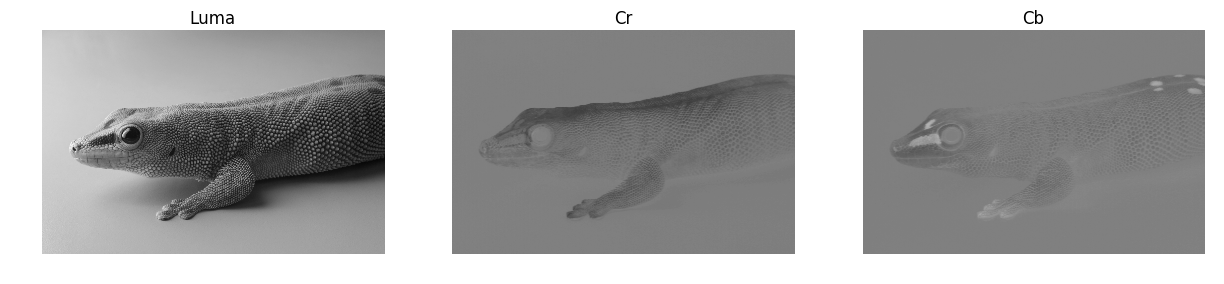

In [32]:
%matplotlib inline

import numpy as np
from scipy.ndimage  import imread
import matplotlib.pyplot as plt

def showPlanes(im):
    plt.figure(figsize=(15,10))
    plt.subplot(1,3,1)
    showImage(im[:,:,0], "Luma")
    plt.subplot(1,3,2)
    showImage(im[:,:,1], "Cr")
    plt.subplot(1,3,3)
    showImage(im[:,:,2], "Cb")


def showImage(im, title):
    plt.imshow(im, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)
    plt.axis('off')
    plt.title(title)
    

im = imread("../../videos/lizard.jpg", mode="YCbCr")
showPlanes(im)



from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('#toggle').attr('value', 'Show code')  
 } else {
 $('div.input').show();
 $('#toggle').attr('value', 'Hide code') 
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggle" value="Show code"></form>''')

In this document, we present the proposed CfL approach for the AV1 Codec. This new version of CfL draws from the strengths of the Cfl implementation of the Thor codec and the Cfl implementation of the Daala codec. 

In [[1]](https://tools.ietf.org/html/draft-midtskogen-netvc-chromapred-02), Midtskogen proposes to compute $\alpha$ and $\beta$ using the predicted values of Luma and Chroma. These values are available in both the encoder and decoder. As such, they are not signaled in the bitstream. Additionally, Midtskogen uses a threshold of 64 on the mean squared error between the reconstructed Luma pixel and the predicted Luma pixel to decide whether or not CfL should be used. An important note about the work of Midtskogen is that it applies to intra frame coding and inter frame coding.

In [[2]](https://people.xiph.org/~unlord/spie_cfl.pdf), Egge and Valin propose a frequency domain version of CfL. the authors exploit the gain-shape coding nature of perceptual vector quantization (PVQ) to avoid having to perform model fitting to find $\alpha$ and $\beta$. As such, only a sign bit needs to be signaled. It is important to note that this version of CfL only predicts ACs coefficients.

The proposed solution is similar to [1] in the it is performed in the spatial domain and least squares is used. However, it differs from [1] in that $\alpha$ is signaled in the bitstream. As for $\beta$, Midtskogen computes it using the least squares equation, we propose to use DC_PRED as the value of $\beta$. This aligns with [2], in that CfL does not predict the DC.

The characteristics of the different CfL implementations are described in the following table.

|                                | Thor[1]    | Daala[1]  | Proposed |
|--------------------------------|------------|-----------|----------|
| Prediction Domain              | Spatial    | Frequency | Spatial  |
| Bitstream Signaling            | None       | Sign bit  | Alpha    |
| Encoder model fitting          | Yes        | Via PVQ   | Yes      |
| Decoder model fitting          | Yes        | No        | No       |
| Luma values used for fit       | Predicted  | Luma      | Luma     |
| Chroma values used for fit     | Predicted  | Chroma    | Chroma   |


## CfL Fundamentals

Although it does not always hold, the assumption of a linear relationship between the luma plane and its chromatic counterparts is not farfetched. For example, the following image shows the relationship between the Luma and Chroma for an $8 \times 8$ block in the previous lizard image.


(95, 135)

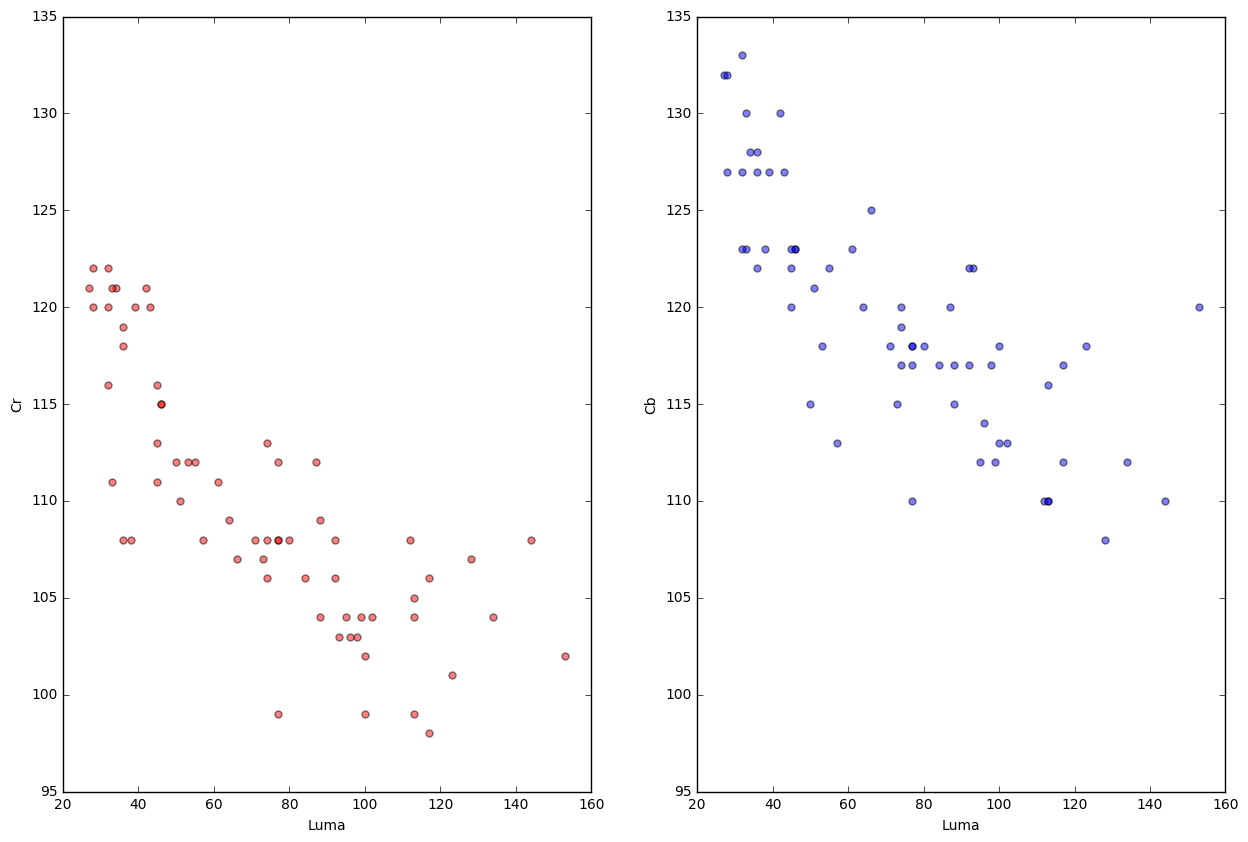

In [43]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.scatter(im[300:308,500:508,0].ravel(), im[300:308,500:508,1].ravel(), c="red", alpha=0.5, s=25)
plt.xlabel("Luma")
plt.ylabel("Cr")
plt.gca().set_ylim([95, 135])
plt.subplot(1,2,2)
plt.scatter(im[300:308,500:508,0].ravel(), im[300:308,500:508,2].ravel(), c="blue", alpha=0.5, s=25)
plt.xlabel("Luma")
plt.ylabel("Cb")
plt.gca().set_ylim([95, 135])

Assuming that this relationship also exists between the $i$th reconstructed Luma pixel $\hat{L}_i$ and $i$th Chroma pixel $C_i$, 
a chromatic prediction of $C_i$ can be computed using the following equation

$$C'_i = \alpha \times \hat{L}_i + \beta,$$

where $\alpha$ is the slope and $\beta$ is y intercept. For a block of $N$ pixels, $\alpha$ and $\beta$ are computed with the least squares equations as follows

$$\alpha = \frac{N \sum_i \hat{L}_i C_i - \sum_i \hat{L}_i \sum_i C_i}{N \sum_i L_i^2 - (\sum \hat{L}_i)^2},$$

$$\beta = \frac{\sum_i C_i - \alpha \sum_i \hat{L}_i}{N}.$$

As explained in [1], signaling $\alpha$ and $\beta$ on a per block basis is too expensive. To avoid signaling these parameters, Midtskogen proposes instead to compute $\alpha'$ and $\beta'$ by replacing the actual values $\hat{L}$ and $C$ by their predicted counterparts $L'$ and $C'$. The advantage of such and approach is that $L'$ and $C'$ are available to both the encoder and decoder, the model fitting is performed during encoding and during decoding, thus signaling alpha and beta is avoided. The disadvantage of this approach is that the model will fit the prediction but not the actual data. In the context of intra coding, the prediction might significantly differ from the actual values. This loss of precision will increase distortion and rate.

Fitting the model on the real values of $\hat{L}$ and $C$ generates a more precise model. However, this information is not available to the decoder and must be signaled in the bitstream. In this proposal, we will present different techniques to reduce the rate required to signal the model fitting parameters.

Let $\bar{L}$ be the subtraction of $\hat{L}$ by its average for a given block. Notice that $\bar{L}$ is zero mean, it follows that

$$\sum_i \bar{L_i} = 0.$$

Notice that when we replace $\hat{L}$ with $\bar{L}$ in the equation of $\beta$, we get the average chromatic pixel value. It just so happens that the intra prediction mode DC_PRED is designed to predict the average pixel value.

Next, let $\bar{C'}$ be the subtraction of $C$ by the predicted average using DC_PRED.

Replacing $\hat{L}$ by $\bar{L}$ and $C$ with $\bar{C'}$ in the equations of $\alpha$ and $\beta$ yields

$$\bar{\alpha} = \frac{\sum_i \bar{L}_i \bar{C'}_i}{\sum_i \bar{L}_i^2},$$

$$\bar{\beta} = \frac{\sum_i \bar{C'}_i}{N}.$$

Notice that $\bar{\beta}$ is the average of the residual of the chromatic block.

Based on the assumption that $\bar{\beta} \approx 0$, we predict chroma as follows

$$ C''_i = \bar{\alpha} \times \bar{L_i} + DC\_PRED $$

_Note that it could also be possible to signal $\sum_i \bar{L_i} \bar{C'_i}$ instead of $\alpha$. However, signaling $\alpha$ give better results._

## Quantization

Considering the distribution of the values of $\alpha$, it appears that alpha is most often between -2 and 2. As such, not that much precision is required




In [42]:
block_size = 8
(height, width, z) = im.shape

for y in range(0, height, block_size):
    for x in range(0, width, block_size):
        by = im[]
        bc


## References
[1] Steinar Midtskogen,"Improved chroma prediction" IETF draft-midtskogen-netvc-chromapred-02 https://tools.ietf.org/html/draft-midtskogen-netvc-chromapred-02 (October 2016)

[2] Nathan E. Egge and Jean-Marc Valin, "Predicting Chroma from Luma with Frequency Domain Intra Prediction", https://people.xiph.org/~unlord/spie_cfl.pdf (April 2016)